In [2]:
import numpy as np
import pandas as pd
import mne
import os
import mne_icalabel
import matplotlib.pyplot as plt
from mne import find_events
from glob import glob
from scipy import signal
from scipy.stats import zscore
from mne.preprocessing import ICA
# from mne.preprocessing import AMICA
from sklearn.decomposition import FastICA
from mne_icalabel import label_components
from mpl_toolkits.mplot3d import Axes3D

In [2]:
os.environ['OMP_NUM_THREADS'] = '4'

In [2]:
all_file_path = glob('../data-files/*.set')
print(len(all_file_path))

120


In [4]:
os.path.basename(all_file_path[3])[8]

'2'

In [3]:
rest_files_path = [i for i in all_file_path if 'r' == os.path.basename(i)[8]]
zerob_files_path = [i for i in all_file_path if '0' == os.path.basename(i)[8]]
# oneb_files_path = [i for i in all_file_path if '1' == os.path.basename(i)[8]]
# twob_files_path = [i for i in all_file_path if '2' == os.path.basename(i)[8]]

print(rest_files_path)

['../data-files/sb01-s1-rest.set', '../data-files/sb06-s2-rest.set', '../data-files/sb02-s1-rest.set', '../data-files/sb01-s2-rest.set', '../data-files/sb06-s1-rest.set', '../data-files/sb03-s1-rest.set', '../data-files/sb08-s1-rest.set', '../data-files/sb10-s3-rest.set', '../data-files/sb05-s1-rest.set', '../data-files/sb08-s2-rest.set', '../data-files/sb09-s3-rest.set', '../data-files/sb09-s2-rest.set', '../data-files/sb01-s3-rest.set', '../data-files/sb06-s3-rest.set', '../data-files/sb03-s3-rest.set', '../data-files/sb07-s1-rest.set', '../data-files/sb07-s2-rest.set', '../data-files/sb04-s3-rest.set', '../data-files/sb10-s2-rest.set', '../data-files/sb05-s2-rest.set', '../data-files/sb10-s1-rest.set', '../data-files/sb04-s1-rest.set', '../data-files/sb02-s2-rest.set', '../data-files/sb02-s3-rest.set', '../data-files/sb04-s2-rest.set', '../data-files/sb09-s1-rest.set', '../data-files/sb03-s2-rest.set', '../data-files/sb05-s3-rest.set', '../data-files/sb07-s3-rest.set', '../data-file

In [4]:
def readfile(file_path):
    
    # load the EEG data
    eeg = mne.io.read_raw_eeglab(file_path, preload = True)
    
    # perfroming channel selection
    channels = ['F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2']
    eeg = eeg.pick_channels(channels)
    
    # get the task name from the file path
    task = os.path.basename(file_path)[8:]
    
    # specify the event IDs to consider druing epoching for the each task
    included_events = []
    if task == '0back.set':
        included_events = ['6021', '6022']
    elif task == '1back.set':
        included_events = ['6121', '6122']
    elif task == '2back.set':
        included_events = ['6221', '6222']
    
    # include only the specified events in the annotations
    include_annots = included_events
    include_mask = [annot in include_annots for annot in eeg.annotations.description]
    included_annotations = mne.Annotations(onset=eeg.annotations.onset[include_mask], duration=eeg.annotations.duration[include_mask],description=eeg.annotations.description[include_mask])
    eeg.set_annotations(included_annotations)
    
    # extract events from the annotations and exclude any events not considered for epoching
    events, events_id = mne.events_from_annotations(eeg, event_id=None)
    events = events[events[:, 2] <= len(include_annots)]
    event_id = {include_annots[i]: i + 1 for i in range(len(include_annots))}
    
    # rereference the data to the average reference and apply a bandpass filter
    eeg.set_eeg_reference()
    eeg.filter(l_freq=0.5, h_freq=45)
    
    # apply a notch filter to remove line noise
    eeg.notch_filter(freqs=50)
    
    # replace NaN values with the mean of neighboring values
    data = eeg.get_data()
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if np.isnan(data[i,j]):
                data[i,j] = np.mean([data[i-1,j], data[i+1,j]])

    # specify the time window for the epochs
    tmin, tmax = -0.05, 0.7
    
    # create epochs using the extracted events and time window
    if len(events) > 0:
        epochs = mne.Epochs(mne.io.RawArray(data, eeg.info), events, event_id=event_id, tmin=tmin, tmax=tmax, baseline=(None, 0))
        return epochs
    # if no events were found, create fixed-length epochs, this is required for epoching rest data that does not have any events
    else:
        epochs = mne.make_fixed_length_epochs(mne.io.RawArray(data, eeg.info), duration=0.752, overlap=0.34)
        return epochs

#### Using ICA for artifact removal and then Normalizing the data using z-score normalization 

In [5]:
def ica_norm(data):
    
    # Get the epoched EEG data from the MNE-Python data object
    sample_data = data.get_data()
    
    # Apply ICA to the epoched EEG data
    ica = ICA(n_components=sample_data.shape[1])
    ica.fit(data)
    
    # Get the ICA component labels using the ICLabel algorithm
    ica_labels = label_components(inst=data, ica=ica, method='iclabel')
    
    # Define the probability threshold for rejecting ICA components
    threshold = 0.9
    
    # Get the indices of the ICA components with probability greater than or equal to the threshold
    reject_ic, = np.where(ica_labels['y_pred_proba'] >= threshold)
    
    # Exclude the selected ICA components from the data
    ica.exclude = reject_ic
    clean_data = ica.apply(data, exclude=reject_ic)
    
    # Get the cleaned and normalized data
    clean_sample_data = clean_data.get_data()
    sample_data_z = zscore(clean_sample_data, axis=2)
    
    # Return the normalized data
    return sample_data_z

### Loading, filtering and epoching the eeg data

In [6]:
%%capture
control_epochs = [readfile(i) for i in rest_files_path]
zerob_epochs = [readfile(i) for i in zerob_files_path]
# oneb_epochs = [readfile(i) for i in oneb_files_path]
# twob_epochs = [readfile(i) for i in twob_files_path]

In [7]:
control_epochs[0].get_data().shape

Using data from preloaded Raw for 144 events and 376 original time points ...
0 bad epochs dropped


(144, 14, 376)

## Testing ICA

In [7]:
control_sample = control_epochs[0].get_data()

Using data from preloaded Raw for 144 events and 376 original time points ...


In [9]:
ica = ICA(n_components=control_sample.shape[1])

In [1]:
ica.fit(control_epochs[0])

NameError: name 'ica' is not defined

#### Loading data into memory

In [8]:
%%capture
for e in control_epochs:
    e.load_data()
    
for e in zerob_epochs:
    e.load_data()

In [9]:
zerob_epochs[0].get_data().shape

(144, 14, 376)

In [11]:
control_epochs_array = []
zerob_epochs_array = []

In [10]:
control_epochs_array = [ica_norm(e) for e in control_epochs]

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 2.9s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.6) and smallest (3.8e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 4.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.8) and smallest (1.1e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 25.8s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.6) and smallest (2.5e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.7) and smallest (4.6e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.1s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (7.3e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted 

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.8) and smallest (3.2e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 13 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.3s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6) and smallest (5.2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.6) and smallest (2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (3.7e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (2.3e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 7 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.7) and smallest (9.2e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.9) and smallest (4.8e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.6s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.4) and smallest (5.2e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 7 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 5.1s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (10) and smallest (6.8e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.6s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.7) and smallest (5.8e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.3) and smallest (5.1e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.3) and smallest (2.2e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.1s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.2) and smallest (3.1e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.3) and smallest (9.2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.4s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.2) and smallest (2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 0.9s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.6) and smallest (5.1e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.4s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.3) and smallest (2e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted w

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.7s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.1) and smallest (1.1e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (14) and smallest (6.3e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 26.4s.


/home/rahul/.local/lib/python3.10/site-packages/sklearn/decomposition/_fastica.py:123: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.4) and smallest (4.4e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.8) and smallest (3.2e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.3s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (3.3e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.1) and smallest (4.3e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components
Fitting ICA took 4.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.1) and smallest (4.7e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components


In [11]:
zerob_epochs_array = [ica_norm(e) for e in zerob_epochs]

Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.6s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (9.3e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.5) and smallest (1.5e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.1) and smallest (7.6e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 4.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (1.7e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (8.5e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (1e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (11) and smallest (3.9e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.9s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (3e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.6) and smallest (6.6e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (1.2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 13 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.4) and smallest (9.4e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 2.1s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.8) and smallest (6.2e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.1s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.8) and smallest (1e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (8.8) and smallest (1.5e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7) and smallest (9.1e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.1s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.5) and smallest (4.7e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.4s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (13) and smallest (2e-28) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_pa

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.9) and smallest (5.6e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.3) and smallest (6.8e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 9 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.5s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.9) and smallest (9.9e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (5.2) and smallest (1.1e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 0.7s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.1) and smallest (1.3e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 8 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 8.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.9) and smallest (1.7e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.3s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.6e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.3s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (6.4) and smallest (1.7e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 12 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 2.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.9) and smallest (4.9e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.8s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (4.7) and smallest (1.5e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 6 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 1.2s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (9.6) and smallest (5e-27) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit_p

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 11 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 13.9s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.8) and smallest (1.1e-25) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components
Fitting ICA to data using 14 channels (please be patient, this may take a while)
Selecting by number: 14 components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)
/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(data)


Fitting ICA took 2.0s.


/tmp/ipykernel_33299/4226579625.py:8: RuntimeWarning: Using n_components=14 (resulting in n_components_=14) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.2) and smallest (7.5e-26) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 13
  ica.fit(data)
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ica_labels = label_components(inst=data, ica=ica, method='iclabel')
/tmp/ipykernel_33299/4226579625.py:11: RuntimeWarning: The provided ICA instance was fitted with a 'fastica' algorithm. ICLabel was designed with extended infomax ICA decompositions. To use the extended infomax algorithm, use the 'mne.preprocessing.ICA' instance with the arguments 'ICA(method='infomax', fit

Applying ICA to Epochs instance
    Transforming to ICA space (14 components)
    Zeroing out 10 ICA components
    Projecting back using 14 PCA components


/tmp/ipykernel_33299/4226579625.py:21: RuntimeWarning: The data you passed to ICA.apply() was baseline-corrected. Please note that ICA can introduce DC shifts, therefore you may wish to consider baseline-correcting the cleaned data again.
  clean_data = ica.apply(data, exclude=reject_ic)


In [12]:
display(zerob_epochs_array[0].shape, control_epochs_array[0].shape)

(144, 14, 376)

(144, 14, 376)

In [13]:
control_epochs_labels = [len(i)*[0] for i in control_epochs_array]
zerob_epochs_labels = [len(i)*[1] for i in zerob_epochs_array]
# oneb_epochs_labels = [len(i)*[0] for i in oneb_epochs_array]
# twob_epochs_labels = [len(i)*[0] for i in twob_epochs_array]

display(len(control_epochs_labels), len(zerob_epochs_labels))
# , len(oneb_epochs_labels), len(twob_epochs_labels)

30

30

In [14]:
data_list = control_epochs_array + zerob_epochs_array
# + oneb_epochs_array + twob_epochs_array
label_list = control_epochs_labels + zerob_epochs_labels
# + oneb_epochs_labels + twob_epochs_labels

In [15]:
data_array = np.vstack(data_list)
label_array = np.hstack(label_list)

display(data_array.shape, label_array.shape)

(8640, 14, 376)

(8640,)

In [22]:
np.save('cleaned_data.npy', data_array)

In [ ]:
np.save('labels.npy', label_array)

In [16]:
display(type(data_array), type(label_array))

numpy.ndarray

numpy.ndarray

## Plotting Graphs

In [3]:
data = np.load('./cleaned_data.npy')

In [8]:
rest_15 = data[2159:2255, : , :]
zerob_15 = data[6336:6432, : , :]
display(rest_15.shape, zerob_15.shape)

(96, 14, 376)

(96, 14, 376)

In [9]:
rest_avg = np.mean(rest_15, axis=1)
zerob_avg = np.mean(zerob_15, axis=1)
display(zerob_avg.shape, rest_avg.shape)

(96, 376)

(96, 376)

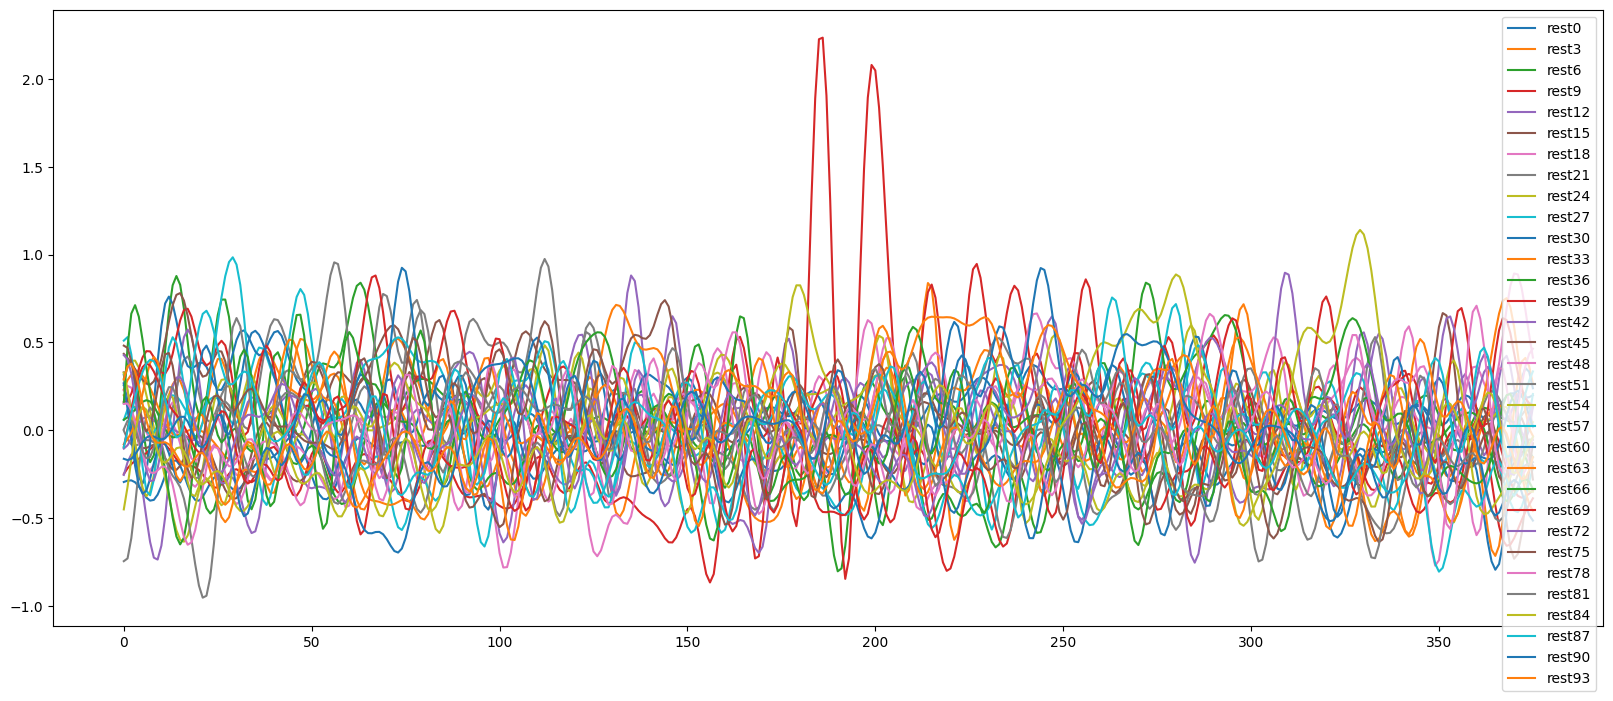

In [13]:
plt.figure(figsize=(20, 8))
for i in range(rest_avg.shape[0]):
  if i%3 == 0:
    plt.plot(rest_avg[i], label='rest{}'.format(i))
plt.legend()

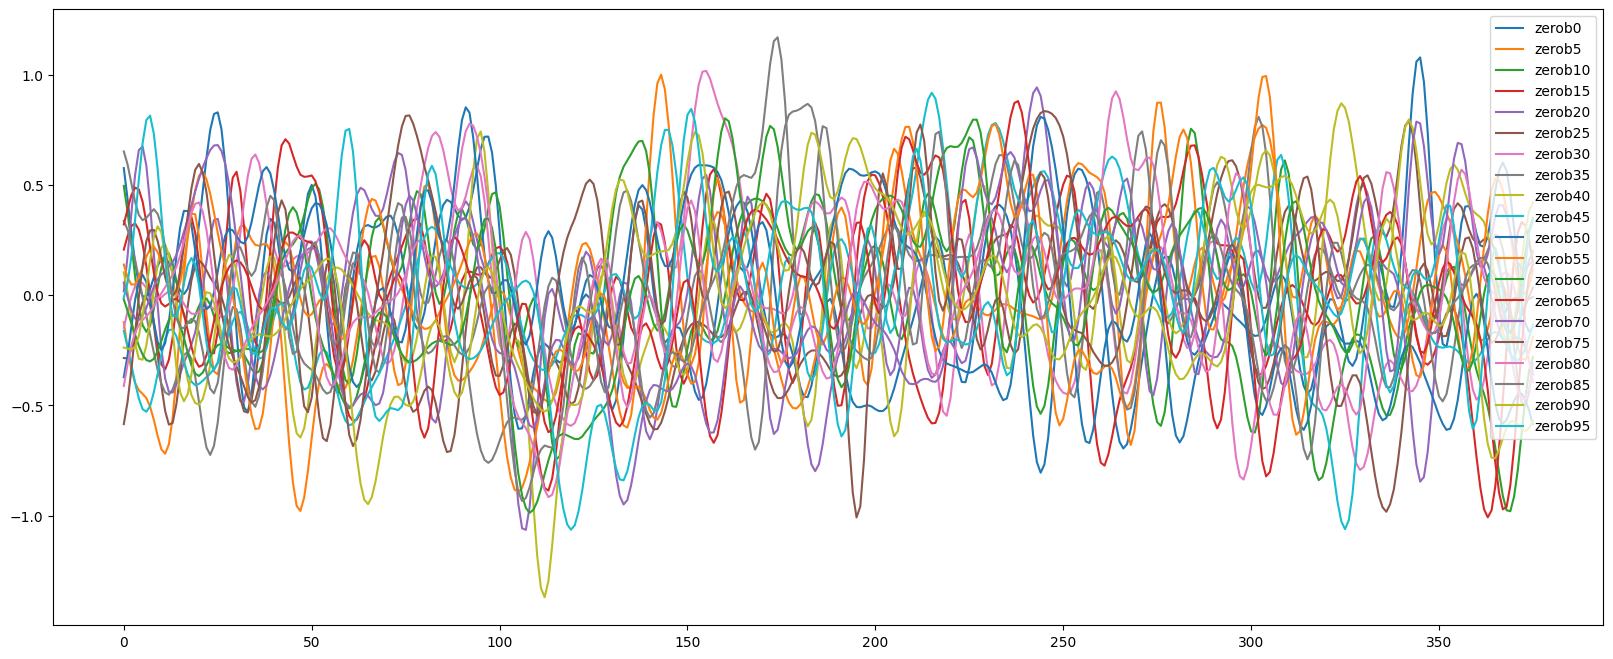

In [15]:
plt.figure(figsize=(20, 8))
for i in range(zerob_avg.shape[0]):
  if i%5 == 0:
    plt.plot(zerob_avg[i], label='zerob{}'.format(i))
plt.legend()

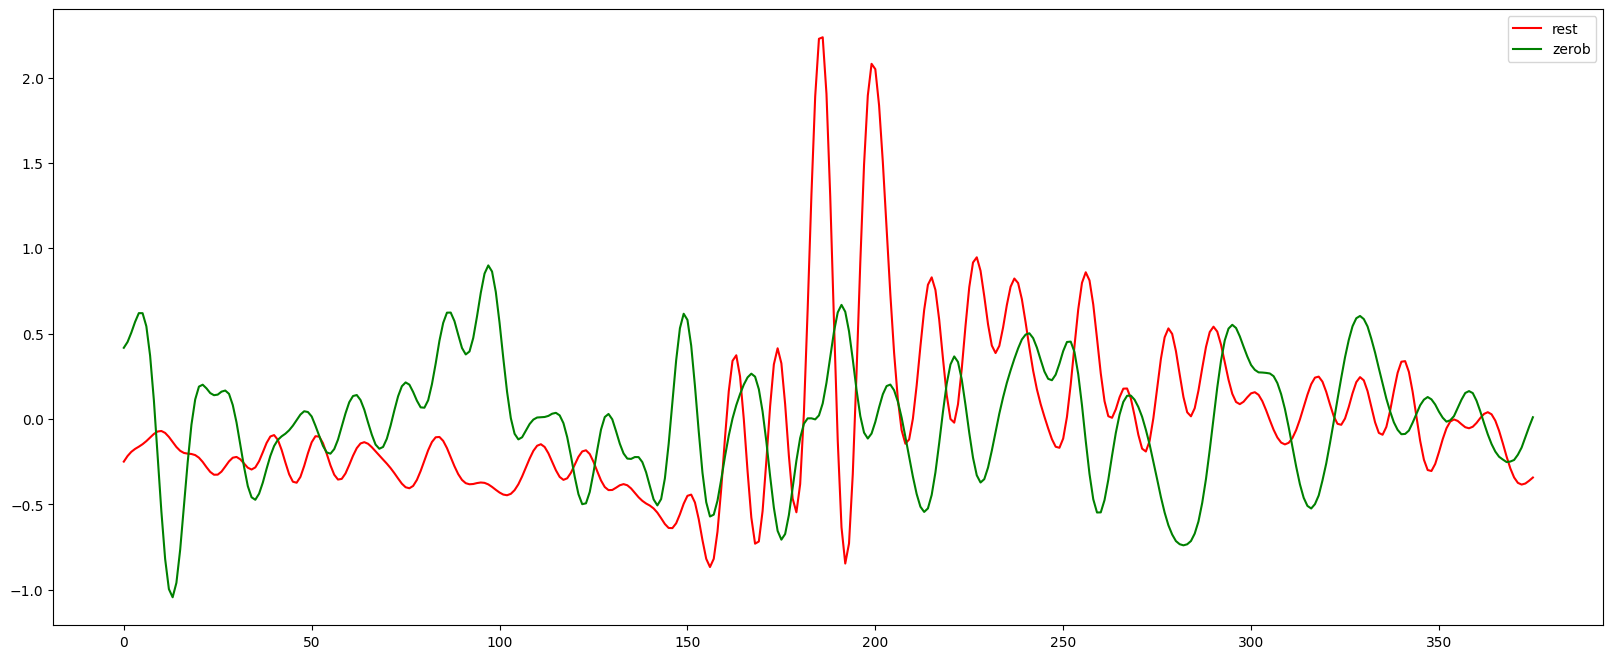

In [31]:
plt.figure(figsize=(20, 8))
for i in range(zerob_avg.shape[0]):
  if i == 9:
    plt.plot(rest_avg[i], color='red', label='rest')
    plt.plot(zerob_avg[i], color='green', label='zerob')
plt.legend()

### Feature Extraction

In [15]:
def maxPwelch_epochs(epochs, Fs):
    
    n_epochs, n_channels, n_samples_per_epoch = epochs.shape
    BandF = [4, 8, 10, 12, 18, 30, 100]
    PMax = np.zeros([n_epochs, n_channels, len(BandF)-1])
    
    for i in range(n_epochs):
        for j in range(n_channels):
            f,Psd = signal.welch(epochs[i,j,:], Fs)

            if np.any(np.isnan(Psd)):
                Psd[np.isnan(Psd)] = 0
            
            for k in range(len(BandF)-1):
                fr = np.where((f>BandF[k]) & (f<=BandF[k+1]))
                PMax[i,j,k] = np.max(Psd[fr])
    
    return PMax


In [16]:
# feature_3dmatrix = [maxPwelch_epochs(i, Fs=500) for i in data_array]
feature_3dmatrix = maxPwelch_epochs(data_array, Fs=500)

In [17]:
display((feature_3dmatrix.shape))

(8640, 14, 6)

### 3D Matrix to 2D Matrix Flatten Function

In [17]:
def flatten(data):
    flattened_data = data.reshape(data.shape[0], -1)
    return flattened_data

In [19]:
feature_2dmatrix = flatten(feature_3dmatrix)

In [20]:
display(feature_2dmatrix.shape)

(8640, 84)

In [21]:
labeled_feature_matrix = np.concatenate((feature_2dmatrix, label_array[:, np.newaxis]), axis=1)
display(labeled_feature_matrix.shape)

(8640, 85)

In [115]:
df = pd.DataFrame(labeled_feature_matrix)
display(df)

,0,1,2,3,4,5,6,7,8,9,...,75,76,77,78,79,80,81,82,83,84
0,0.033660,0.020035,0.023638,0.009187,0.011894,0.014430,0.033839,0.018886,0.022750,0.009146,...,0.007538,0.018749,0.019840,0.048270,0.012913,0.007649,0.012159,0.019602,0.017663,0.0
1,0.005519,0.000903,0.005522,0.020184,0.003774,0.014033,0.005381,0.000894,0.005546,0.020262,...,0.000448,0.001691,0.000963,0.008995,0.000109,0.008473,0.004203,0.006206,0.002329,0.0
2,0.021480,0.021880,0.002681,0.004444,0.010570,0.016766,0.021866,0.022218,0.002611,0.004120,...,0.003342,0.003965,0.003886,0.021194,0.003016,0.000016,0.003583,0.003424,0.002926,0.0
3,0.012345,0.010984,0.017565,0.002979,0.021804,0.020067,0.012293,0.010835,0.017496,0.002944,...,0.012175,0.048283,0.009739,0.037809,0.005898,0.003839,0.010984,0.005170,0.017058,0.0
4,0.009331,0.003621,0.004569,0.013884,0.013799,0.034348,0.009242,0.003715,0.004554,0.013554,...,0.000718,0.005571,0.010520,0.005753,0.000924,0.001628,0.006364,0.007822,0.005407,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8635,0.002951,0.017562,0.009489,0.015822,0.017251,0.022695,0.004292,0.017800,0.007742,0.017309,...,0.035215,0.037053,0.042921,0.010691,0.020183,0.020742,0.033731,0.019541,0.041343,1.0
8636,0.022462,0.004551,0.004490,0.022909,0.063505,0.025875,0.026740,0.001987,0.002049,0.018691,...,0.024301,0.044897,0.019741,0.032855,0.010459,0.016105,0.009377,0.063858,0.017006,1.0
8637,0.048770,0.047570,0.015956,0.055713,0.022994,0.054707,0.046563,0.041062,0.021130,0.052393,...,0.008642,0.031185,0.048371,0.036617,0.013771,0.032938,0.010180,0.051789,0.051403,1.0
8638,0.022316,0.010526,0.033736,0.009491,0.105745,0.011411,0.022957,0.010268,0.035516,0.009005,...,0.009601,0.017088,0.021180,0.034573,0.016203,0.026352,0.006077,0.068108,0.022509,1.0


In [22]:
np.savetxt('labeled_feature_matrix.csv', labeled_feature_matrix, delimiter=',')
# df.to_csv('labeled_feature_matrix.csv', index=False)